In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


#Data Loading
def load_data():
    train = pd.read_csv("course_project_train.csv")
    test = pd.read_csv("course_project_test.csv")
    return train, test

train, test = load_data()

print(train.head())
train.info()

  Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN      

# EDA
# Target distribution

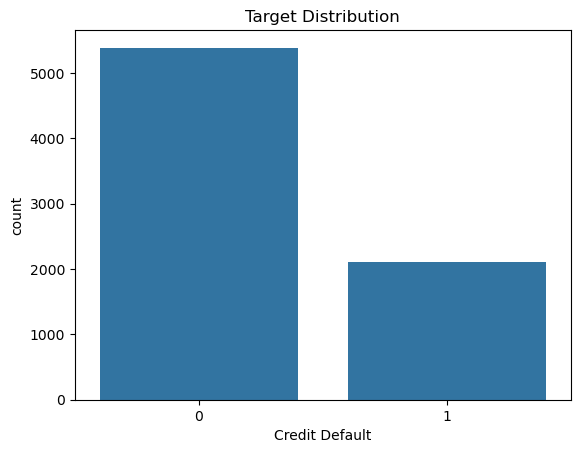

In [3]:
sns.countplot(x='Credit Default', data=train)
plt.title("Target Distribution")
plt.show()

# Missing values

In [4]:
print("\nMissing values:")
print(train.isna().sum().sort_values(ascending=False))


Missing values:
Months since last delinquent    4081
Credit Score                    1557
Annual Income                   1557
Years in current job             371
Bankruptcies                      14
Purpose                            0
Monthly Debt                       0
Current Credit Balance             0
Current Loan Amount                0
Term                               0
Home Ownership                     0
Number of Credit Problems          0
Maximum Open Credit                0
Years of Credit History            0
Number of Open Accounts            0
Tax Liens                          0
Credit Default                     0
dtype: int64


# Correlation (numeric only)

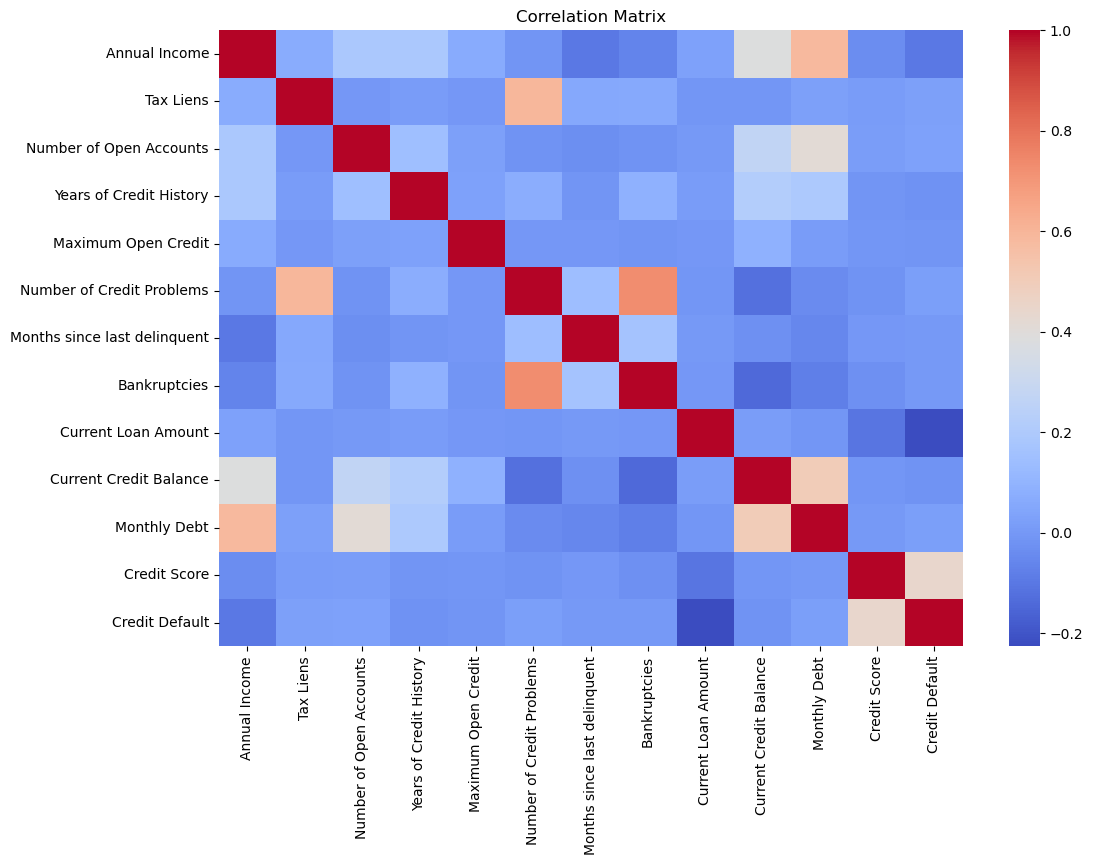

In [6]:
numeric_train = train.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_train.corr(), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Train / Validation Split

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, valid_idx in split.split(train, train["Credit Default"]):
    strat_train = train.loc[train_idx]
    strat_valid = train.loc[valid_idx]

X_train = strat_train.drop("Credit Default", axis=1)
y_train = strat_train["Credit Default"]

X_valid = strat_valid.drop("Credit Default", axis=1)
y_valid = strat_valid["Credit Default"]

# Preprocessing Pipeline

In [8]:
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Baseline Model – Logistic Regression

In [9]:
log_model = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=3000,
        random_state=42
    ))
])

log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_valid)
log_probs = log_model.predict_proba(X_valid)[:,1]

print("\n logistic regression ")
print("F1:", f1_score(y_valid, log_preds))
print("ROC-AUC:", roc_auc_score(y_valid, log_probs))
print(classification_report(y_valid, log_preds))


 logistic regression 
F1: 0.5166498486377397
ROC-AUC: 0.7540010228921507
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1077
           1       0.45      0.61      0.52       423

    accuracy                           0.68      1500
   macro avg       0.64      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500



# Threshold Optimization 

In [10]:
best_log_f1 = 0
best_log_t = 0

for t in np.arange(0.1, 0.9, 0.02):
    preds_t = (log_probs >= t).astype(int)
    score = f1_score(y_valid, preds_t)
    if score > best_log_f1:
        best_log_f1 = score
        best_log_t = t

print("Best Logistic threshold:", best_log_t)
print("Best Logistic F1:", best_log_f1)

Best Logistic threshold: 0.4600000000000001
Best Logistic F1: 0.5353095030514385


# Random Forest 

In [11]:
rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=6,
        class_weight="balanced",
        random_state=42
    ))
])

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [4, 6, 8]
}

grid = GridSearchCV(
    rf_model,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

rf_preds = best_model.predict(X_valid)
rf_probs = best_model.predict_proba(X_valid)[:,1]

print("\n randon forests ")
print("F1:", f1_score(y_valid, rf_preds))
print("ROC-AUC:", roc_auc_score(y_valid, rf_probs))
print(classification_report(y_valid, rf_preds))



 randon forests 
F1: 0.5308775731310943
ROC-AUC: 0.7617232001158986
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1077
           1       0.49      0.58      0.53       423

    accuracy                           0.71      1500
   macro avg       0.66      0.67      0.66      1500
weighted avg       0.73      0.71      0.72      1500




# Threshold optimization (Random Forest)

In [12]:
best_rf_f1 = 0
best_rf_t = 0

for t in np.arange(0.1, 0.9, 0.02):
    preds_t = (rf_probs >= t).astype(int)
    score = f1_score(y_valid, preds_t)
    if score > best_rf_f1:
        best_rf_f1 = score
        best_rf_t = t

print("Best RF threshold:", best_rf_t)
print("Best RF F1:", best_rf_f1)

Best RF threshold: 0.44000000000000006
Best RF F1: 0.537602382725242


# Confusion Matrix

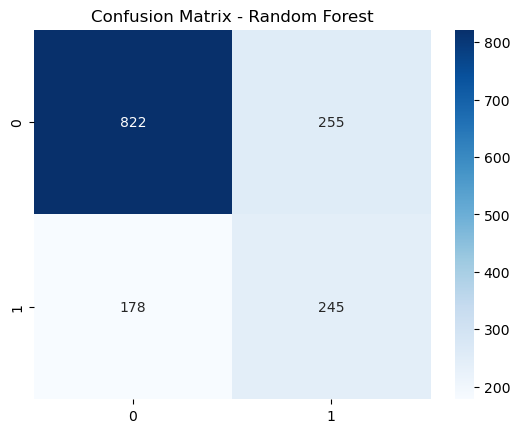

In [13]:
sns.heatmap(confusion_matrix(y_valid, rf_preds),
            annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Feature Importance

In [14]:
importances = best_model.named_steps["model"].feature_importances_

feature_names = (
    num_features.tolist() +
    list(best_model.named_steps["prep"]
         .named_transformers_["cat"]
         .named_steps["encoder"]
         .get_feature_names_out(cat_features))
)

feat_importance = pd.Series(importances, index=feature_names)\
                    .sort_values(ascending=False)

print("\nTop 10 Important Features:")
print(feat_importance.head(10))


Top 10 Important Features:
Credit Score               0.336267
Current Loan Amount        0.253232
Term_Long Term             0.083883
Term_Short Term            0.073513
Annual Income              0.069688
Maximum Open Credit        0.032652
Monthly Debt               0.023962
Years of Credit History    0.020129
Current Credit Balance     0.019997
Number of Open Accounts    0.014503
dtype: float64


# Custom Logistic Regression 


In [15]:
class CustomLogisticRegression:
    def __init__(self, lr=0.01, n_iter=3000):
        self.lr = lr
        self.n_iter = n_iter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        self.theta = np.zeros(X.shape[1])

        for _ in range(self.n_iter):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        probs = self.sigmoid(np.dot(X, self.theta))
        return (probs >= 0.5).astype(int)

X_train_prepared = preprocessor.fit_transform(X_train)
X_valid_prepared = preprocessor.transform(X_valid)

custom_model = CustomLogisticRegression()
custom_model.fit(X_train_prepared, y_train.values)

custom_preds = custom_model.predict(X_valid_prepared)

print("\n custom logistic ")
print("F1:", f1_score(y_valid, custom_preds))


 custom logistic 
F1: 0.38345864661654133


# Final Prediction for Test

In [16]:
final_probs = best_model.predict_proba(test)[:,1]
final_preds = (final_probs >= best_rf_t).astype(int)

submission = pd.DataFrame({
    "Id": test.index,
    "Credit Default": final_preds
})

submission.to_csv("submission.csv", index=False)

print("\n Final models summary ")
print("Logistic F1:", f1_score(y_valid, log_preds))
print("Random Forest F1:", f1_score(y_valid, rf_preds))
print("Custom Logistic F1:", f1_score(y_valid, custom_preds))


 Final models summary 
Logistic F1: 0.5166498486377397
Random Forest F1: 0.5308775731310943
Custom Logistic F1: 0.38345864661654133
